In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Data preprocessing and visualization
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Regression analysis
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

FYI: the code found in "Prepare the dataset" below is also available as custom module in [my Git repository.](https://github.com/elizabeth-oda/wine_prices/tree/main/wine_prices)

## Prepare the dataset

We'll use the Wine Tasting dataset [available on Kaggle](https://www.kaggle.com/mysarahmadbhat/wine-tasting)

In [3]:
# Adjust path based on your environment
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/wine_prices/winemag-data-130k-v2.csv')

In [4]:
df.head()

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


### Preprocess and clean data

#### Replace null strings with 'None'

In [5]:
print(f'The shape is {df.shape}\n')
df.info()

The shape is (129971, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float6

In [6]:
# Drop rows where the country or variety is null
df = df.dropna(subset=['country','variety'])

In [7]:
# Replace null strings with 'None'
replace_nan = ['designation',
               'region_1',
               'region_2',
               'taster_name',
               'taster_twitter_handle']
for col in replace_nan:
    df[col] = df[col].replace(np.nan, 'None')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Replace missing prices with the mean for their country

In [8]:
# Determine the percentage of missing prices
(df['price'].isna().sum() / df['price'].shape[0]) * 100

6.921874879721647

In [9]:
# Calculate the mean price for each country
df_avg = df[['country','price']]
df_avg = df_avg.groupby(by='country').mean()
df_avg.head()

,price
country,
Argentina,24.510117
Armenia,14.500000
Australia,35.437663
Austria,30.762772
Bosnia and Herzegovina,12.500000


In [10]:
# Takes the average price from df_avg and replaces null prices in df
# The .dropna() drops the one null value remaining
df = df.set_index('country').combine_first(df_avg).reset_index().dropna()

In [11]:
df = df.set_index('id')
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
id,,,,,,,,,,,,,
16,Argentina,"Baked plum, molasses, balsamic vinegar and che...",Felix,87,30.0,Other,Cafayate,None,Michael Schachner,@wineschach,Felix Lavaque 2010 Felix Malbec (Cafayate),Malbec,Felix Lavaque
17,Argentina,Raw black-cherry aromas are direct and simple ...,Winemaker Selection,87,13.0,Mendoza Province,Mendoza,None,Michael Schachner,@wineschach,Gaucho Andino 2011 Winemaker Selection Malbec ...,Malbec,Gaucho Andino
183,Argentina,With attractive melon and other tropical aroma...,None,88,12.0,Other,Salta,None,Michael Schachner,@wineschach,Alamos 2007 Torrontés (Salta),Torrontés,Alamos
224,Argentina,Blackberry and road-tar aromas are dark and st...,Lunta,90,22.0,Mendoza Province,Luján de Cuyo,None,Michael Schachner,@wineschach,Mendel 2014 Lunta Malbec (Luján de Cuyo),Malbec,Mendel
231,Argentina,"Meaty and rubbery, but that's young Bonarda. T...",None,85,10.0,Mendoza Province,Mendoza,None,Michael Schachner,@wineschach,Andean Sky 2007 Bonarda (Mendoza),Bonarda,Andean Sky


#### Manual one-hot-encoding for new world vs. old world countries

In [12]:
# Apologies for the long, ugly lists!
# New world vs. old world classifications from Wine Folly
new_world_list = [
    'Argentina',
    'Australia',
    'Brazil',
    'Canada',
    'Chile',
    'China',
    'Egypt',
    'India',
    'Mexico',
    'New Zealand',
    'Peru',
    'South Africa',
    'US',
    'Uruguay'
]

In [13]:
# Ancient world wines are grouped in with old world wines
old_world_list = [
    'Armenia',
    'Austria',
    'Bosnia and Herzegovina',
    'Bulgaria',
    'Croatia',
    'Cyprus',
    'Czech Republic',
    'England',
    'France',
    'Georgia',
    'Germany',
    'Greece',
    'Hungary',
    'Israel',
    'Italy',
    'Lebanon',
    'Luxembourg',
    'Macedonia',
    'Moldova',
    'Morocco',
    'Portugal',
    'Romania',
    'Serbia',
    'Slovakia',
    'Slovenia',
    'Spain',
    'Switzerland',
    'Turkey',
    'Ukraine'
]    

In [14]:
# Creates boolean masks for new world and old world countries
df['new_world'] = df['country'].apply(lambda x: x in new_world_list)
df['old_world'] = df['country'].apply(lambda x: x in old_world_list)

### Exploratory data analysis

#### Creates separate dataframes with and without price outliers

In [15]:
# Remove price outliers
df_no_outliers = df[(np.abs(stats.zscore(df['price'])) < 3)]

In [16]:
# Original dataframe
df.describe()

,points,price
count,129906.000000,129906.000000
mean,88.447085,35.547989
std,3.040064,39.616034
min,80.000000,4.000000
25%,86.000000,18.000000
50%,88.000000,27.000000
75%,91.000000,41.139120
max,100.000000,3300.000000


In [17]:
# Dataframe without outliers
df_no_outliers.describe()

,points,price
count,128689.000000,128689.000000
mean,88.396926,33.141217
std,2.998895,22.125015
min,80.000000,4.000000
25%,86.000000,18.000000
50%,88.000000,27.000000
75%,91.000000,41.139120
max,100.000000,154.000000


Price distribution excluding outliers


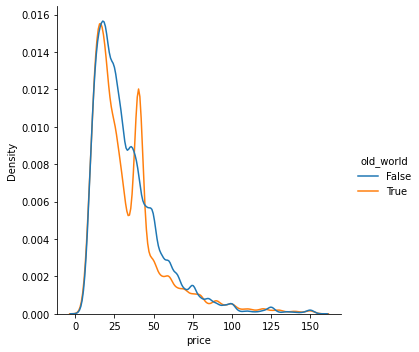

In [18]:
print('Price distribution excluding outliers')
sns.displot(data=df_no_outliers, 
            x='price', 
            hue='old_world',
            kind='kde');

In [19]:
# Let's take a closer look at the outliers
df_outliers = df[(np.abs(stats.zscore(df['price'])) >= 3)]

In [20]:
df_outliers.describe()

,points,price
count,1217.000000,1217.000000
mean,93.751027,290.046836
std,2.671973,224.546019
min,83.000000,155.000000
25%,93.000000,179.000000
50%,94.000000,225.000000
75%,95.000000,310.000000
max,100.000000,3300.000000


Price distribution of outliers


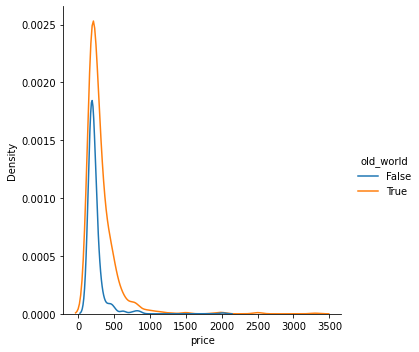

In [21]:
print('Price distribution of outliers')
sns.displot(data=df_outliers, 
            x='price', 
            hue='old_world',
            kind='kde');

#### Correlation heatmapping

Correlation heatmap for all data


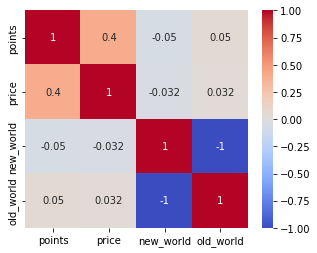

In [22]:
print('Correlation heatmap for all data')
plt.figure(figsize = (5,4))
sns.heatmap(df.corr(), 
            cmap='coolwarm', 
            annot = True, 
            annot_kws={"size": 10});

Initial takeaways from all data:
* Points is moderately correlated (0.4) with price
* New_world has a very small negative correlation (-0.032) with price
* Conversely, old_world has a very small positive correlation (0.032) with price

Correlation heatmap excluding outliers


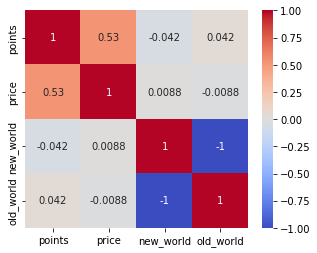

In [23]:
print('Correlation heatmap excluding outliers')
plt.figure(figsize = (5,4))
sns.heatmap(df_no_outliers.corr(), 
            cmap='coolwarm', 
            annot = True, 
            annot_kws={"size": 10});

When outliers are excluded:
* Points is more closely correlated (0.53) with price
* The correlation between old_world and new_world is less pronounced

Correlation heatmap of outliers


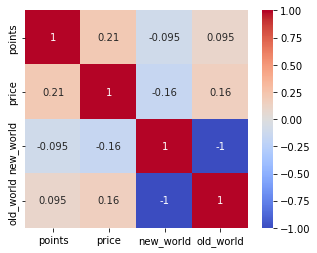

In [24]:
print('Correlation heatmap of outliers')
plt.figure(figsize = (5,4))
sns.heatmap(df_outliers.corr(), 
            cmap='coolwarm', 
            annot = True, 
            annot_kws={"size": 10});

The correlations are substantially different for outliers:
*   Price and points are only slightly correlated (0.21)
*   New_old and old_word have a much greater correlation to price (±0.16) for more expensive outliers than for cheaper wines




#### Interactive plot comparing mean price and points by country

In [25]:
# Creates a smaller dataframe that groups by country
country_avg = df[['points','price','country','variety', 'new_world', 'old_world']]
country_avg = df.groupby('country').mean()
country_avg['count'] = df.groupby('country')['country'].count()
# Converts new_world and old_world to boolean for the sake of plotting
country_avg['new_world'] = country_avg['new_world'].astype('boolean')
country_avg['old_world'] = country_avg['old_world'].astype('boolean')
country_avg = country_avg.reset_index()
country_avg.head()

,country,points,price,new_world,old_world,count
0,Argentina,86.710263,24.510117,True,False,3800
1,Armenia,87.500000,14.500000,False,True,2
2,Australia,88.580507,35.437663,True,False,2329
3,Austria,90.101345,30.762772,False,True,3345
4,Bosnia and Herzegovina,86.500000,12.500000,False,True,2


In [27]:
# Creates an interactive Plotly Express plot
fig = px.scatter(country_avg,
                 x='price', 
                 y='points',
                 size='count', 
                 hover_name='country',
                 color='new_world',
                 size_max=100)
fig.update_xaxes(range=[0, 60])
fig.update_yaxes(range=[84, 92])
fig.show()

In [28]:
# Creates a smaller dataframe that groups by country
country_avg_no_outliers = df_no_outliers[['points','price','country','variety', 'new_world', 'old_world']]
country_avg_no_outliers = df_no_outliers.groupby('country').mean()
country_avg_no_outliers['count'] = df_no_outliers.groupby('country')['country'].count()
# Converts new_world and old_world to boolean for the sake of plotting
country_avg_no_outliers['new_world'] = country_avg_no_outliers['new_world'].astype('boolean')
country_avg_no_outliers['old_world'] = country_avg_no_outliers['old_world'].astype('boolean')
country_avg_no_outliers = country_avg_no_outliers.reset_index()
country_avg_no_outliers.head()

,country,points,price,new_world,old_world,count
0,Argentina,86.692552,23.886277,True,False,3786
1,Armenia,87.500000,14.500000,False,True,2
2,Australia,88.500000,31.385592,True,False,2296
3,Austria,90.098415,30.404270,False,True,3343
4,Bosnia and Herzegovina,86.500000,12.500000,False,True,2


In [29]:
# Creates an interactive Plotly Express plot
fig = px.scatter(country_avg_no_outliers,
                 x='price', 
                 y='points',
                 size='count', 
                 hover_name='country',
                 color='new_world',
                 size_max=100)
fig.update_xaxes(range=[0, 60])
fig.update_yaxes(range=[84, 92])
fig.show()

## Initial linear regression

In [56]:
df_reg = df_no_outliers[['points','price','new_world', 'old_world']]

In [57]:
# Define X and y
X = df_reg[['points', 'new_world', 'old_world']]
y = df_reg['price']

In [58]:
# We'll use a 70/30 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [59]:
# We'll use the RobustScaler because it is less sensitive to outliers
scaler = RobustScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))

In [60]:
# Fit the model on scaled training data
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [67]:
train_score = model.score(X_train, y_train)
print('The training score (r^2) is {:.2f}'.format(train_score))

The training score (r^2) is 0.28


In [62]:
y_pred_train = model.predict(X_train)

In [63]:
# Transform X_test after the train-test split to avoid data leakage
X_test = scaler.transform(X_test)

In [68]:
test_score = model.score(X_test, y_test)
print('The test score (r^2) is {:.2f}'.format(test_score))

The test score (r^2) is 0.28


In [66]:
y_pred_test = model.predict(X_test)

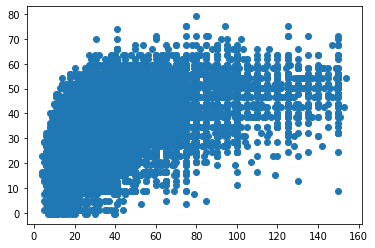

In [70]:
plt.scatter(y_test, y_pred_test);

We're able to explain about 28% of the variance in price by using only points and its new world/old world classification!